# Figure 2c. Marginal vs multicontext effect sign heatmap

## Marginal effect sign heatmap

### posterior table

In [29]:
library(ggplot2)
library(reshape2)
library(stringr)
library(dplyr)
library(data.table)
library(tidyverse)
# replace with the new posterior path in the folder "interactive_sessions/aw3600/mash_prior_0718_posterior/mash_34_contexts_ed_bovy_1e3.EZ.posterior.rds"
posterior_dat <-readRDS("~/project/Figure_2b/adgwas_20k_prune37_ed_bovy_1e3.EZ.posterior.rds")
### transfer the lfsr to the four columns
posterior_dat_lfsr <- as.data.frame(posterior_dat$lfsr)%>%
                     mutate(
                             split_info = str_split(as.character(rownames(posterior_dat$lfsr)), "_", simplify = TRUE),
                             variant = split_info[, 1],
                             gene = split_info[, 2]
                           ) %>%
                     select(-split_info)%>%
                     pivot_longer(
                            cols = -c(variant, gene),  # Keep 'variant' and 'gene' columns fixed
                            names_to = "context",      # New column for context (column names)
                            values_to = "lfsr"  # New column for effect sizes (values)
                     ) 
rownames(posterior_dat_lfsr) <- NULL
posterior_dat_negative_prob <- as.data.frame(posterior_dat$NegativeProb)%>%
                     mutate(
                             split_info = str_split(as.character(rownames(posterior_dat$NegativeProb)), "_", simplify = TRUE),
                             variant = split_info[, 1],
                             gene = split_info[, 2]
                           ) %>%
                     select(-split_info)%>%
                     pivot_longer(
                            cols = -c(variant, gene),  # Keep 'variant' and 'gene' columns fixed
                            names_to = "context",      # New column for context (column names)
                            values_to = "prob"  # New column for effect sizes (values)
                     )
### transfer the posterior_mean to the four columns
posterior_dat_effect <- as.data.frame(posterior_dat$PosteriorMean)%>%
                     mutate(
                             split_info = str_split(as.character(rownames(posterior_dat$PosteriorMean)), "_", simplify = TRUE),
                             variant = split_info[, 1],
                             gene = split_info[, 2]
                           ) %>%
                     select(-split_info)%>%
                     pivot_longer(
                            cols = -c(variant, gene),  # Keep 'variant' and 'gene' columns fixed
                            names_to = "context",      # New column for context (column names)
                            values_to = "effect"  # New column for effect sizes (values)
                     )
posterior_dat_effect$effect_sign <- factor(posterior_dat_effect$effect > 0, 
                                           levels = c(FALSE, TRUE), 
                                           labels = c("-1", "+1"))
rownames(posterior_dat_effect) <- NULL
### integrate lfsr and effec, also effect sign
posterior_dat_lfsr_effect <- posterior_dat_lfsr%>%
                                left_join(posterior_dat_effect,by = c("variant","gene","context"))%>%
                                left_join(posterior_dat_negative_prob, by = c("variant","gene","context"))
lfsr_cutoff <- 0.01
posterior_dat_lfsr_effect_filtered <- posterior_dat_lfsr_effect%>%filter(lfsr<lfsr_cutoff)
posterior_dat_lfsr_effect_filtered_context_top_variants <- posterior_dat_lfsr_effect_filtered_context %>% 
                                                                group_by(gene, context) %>% 
                                                                filter(lfsr == min(lfsr),prob == max(prob)) %>%
                                                                ungroup() %>%
                                                                unique()

In [31]:
coverage <- "cs_coverage_0.95"
intersected_gene_names <- posterior_dat_lfsr_effect_filtered_context_top_variants%>%
                                                        filter(context%in%traits)%>%
                                                        filter(gene%in%as.character(unique(mvsusie_export_lfsr_integrated_df%>%filter(event_ID!="")%>%
                                                                                           filter(.data[[coverage]]!=0)%>%pull(gene_ID)))) %>% pull(gene)%>%unique()
length(intersected_gene_names)

[1] 4037

### trait_matrix

In [33]:
#trait_matrix <- readRDS("~/project/Figure_2b/marginal_efect_sign_0429_4063.rds")
# replace with the new version multicontext top loci table
ROSMAP_multicontext_res <- fread("/data/analysis_result/multi_context/ROSMAP/export/summary/ROSMAP.exported.toploci.bed.gz")
# we split the event_ID in the multicontext top loci table to get `mvsusie_export_lfsr_integrated_df`
mvsusie_export_lfsr_integrated_df <- readRDS("~/project/Figure_2b/multicontext_top_loci_integrated.rds")
traits <- as.character(unique(mvsusie_export_lfsr_integrated_df%>%filter(event_ID!="")%>%pull(event_ID)))
coverage <- "cs_coverage_0.95"
intersected_gene_names <- posterior_dat_lfsr_effect_filtered_context_top_variants%>%
                                                        filter(context%in%traits)%>%
                                                        filter(gene%in%as.character(unique(mvsusie_export_lfsr_integrated_df%>%filter(event_ID!="")%>%
                                                                                           filter(.data[[coverage]]!=0)%>%pull(gene_ID)))) %>% pull(gene)%>%unique()
ROSMAP_multicontext_extracted <- ROSMAP_multicontext_res %>% filter(event_ID!="") %>% filter(gene_ID%in%intersected_gene_names)
posterior_dat_lfsr_effect_filtered_context <- posterior_dat_lfsr_effect_filtered%>%
                                                        filter(context%in%traits)%>%
                                                        filter(gene%in%unique(ROSMAP_multicontext_extracted$gene_ID))
posterior_dat_lfsr_effect_filtered_context_grouped <- posterior_dat_lfsr_effect_filtered_context %>%
  group_by(gene, variant) %>%
  summarise(
    contexts = paste(unique(context), collapse = ","), 
    .groups = "drop"
  )
num_traits <- length(traits)
trait_matrix <- matrix(0, nrow = num_traits, ncol = num_traits)  # Initialize matrix
rownames(trait_matrix) <- colnames(trait_matrix) <- traits   # Assign trait names
for (gene_name in unique(posterior_dat_lfsr_effect_filtered_context_grouped$gene)){
#gene_name <- as.character(unique(mvsusie_export_lfsr_integrated_df$gene))[1]
strong_variants_lfsr_thres <- posterior_dat_lfsr_effect_filtered_context_grouped %>%
  filter(gene == gene_name) %>%
  pull(variant)%>%
  unique()
#Iterate through variants in df2
for (variant_ID in strong_variants_lfsr_thres) {
  # Extract rows from df1 where the marker matches the variant in df2
  variant_data <- posterior_dat_lfsr_effect_filtered_context %>% filter(gene==gene_name)%>%filter(variant == variant_ID)
  # If variant is found in multiple traits, compare effect signs
  if (nrow(variant_data) > 1) {
    
    # Get unique trait pairs
    for (i in 1:(nrow(variant_data) - 1)) {
      for (j in (i + 1):nrow(variant_data)) {
        
        trait_i <- variant_data$context[i]
        trait_j <- variant_data$context[j]
        
        effect_sign_i <- variant_data$effect_sign[i]
        effect_sign_j <- variant_data$effect_sign[j]

        # Find indices in the trait matrix
        idx_i <- which(traits == trait_i)
        idx_j <- which(traits == trait_j)
        
        # Ensure idx_i is always smaller than idx_j for upper triangle updates
        if (idx_i > idx_j) {
              temp <- idx_i
              idx_i <- idx_j
              idx_j <- temp
        }

        # Update matrix correctly with only +1 increments
        if (effect_sign_i == effect_sign_j) {
            trait_matrix[idx_i, idx_j] <- trait_matrix[idx_i, idx_j] + 1  # Always upper triangle
        } else {
            trait_matrix[idx_j, idx_i] <- trait_matrix[idx_j, idx_i] + 1  # Always lower triangle
        }
      }
    }
  } else if (nrow(variant_data) == 1) {
    trait_idx <- which(traits == variant_data$context)
    trait_matrix[trait_idx, trait_idx] <- trait_matrix[trait_idx, trait_idx] + 1 # Diagonal increment
    } 
  }
}

trait_matrix

,AC_DeJager_eQTL,DLPFC_DeJager_eQTL,PCC_DeJager_eQTL,Exc_DeJager_eQTL,Inh_DeJager_eQTL,Oli_DeJager_eQTL,Ast_DeJager_eQTL,DLPFC_Bennett_pQTL,monocyte_ROSMAP_eQTL,OPC_DeJager_eQTL,Mic_DeJager_eQTL
AC_DeJager_eQTL,188,3288,3511,2080,1713,1616,1793,885,398,1095,675
DLPFC_DeJager_eQTL,86,79,3889,2791,2054,1765,1872,969,391,1240,658
PCC_DeJager_eQTL,33,24,18,2657,1961,1588,1799,1038,384,1147,652
Exc_DeJager_eQTL,504,247,309,162,2975,1715,1770,715,337,1345,796
Inh_DeJager_eQTL,431,277,328,64,92,1626,1717,466,303,1347,798
Oli_DeJager_eQTL,308,217,291,285,216,141,1594,384,296,1320,728
Ast_DeJager_eQTL,233,177,210,248,167,168,63,437,270,1388,761
DLPFC_Bennett_pQTL,96,86,64,200,230,186,148,200,116,241,166
monocyte_ROSMAP_eQTL,78,70,84,106,87,62,52,55,127,189,271
OPC_DeJager_eQTL,227,151,183,172,99,114,81,138,37,85,641


### heatmap

In [45]:
# Ensure "AC_DeJager_eQTL" stays on top
#trait_matrix <- readRDS("~/project/Figure_2b/marginal_efect_sign_0429_4063.rds")
trait_matrix <- trait_matrix[order(factor(rownames(trait_matrix), levels = rownames(trait_matrix))), 
                           order(factor(colnames(trait_matrix), levels = rownames(trait_matrix)))]
rev_trait_matrix <- trait_matrix[,ncol(trait_matrix):1]
#rev_trait_matrix <- t(trait_matrix)
rev_trait_matrix <- t(rev_trait_matrix)

# Calculate the fraction matrix
# Assuming rev_trait_matrix is your input square matrix
context_names <- colnames(rev_trait_matrix)
n <- length(context_names)

# Initialize output matrix
proportion_matrix <- matrix(NA, nrow = n, ncol = n)
colnames(proportion_matrix) <- rownames(proportion_matrix) <- context_names 

pairwise_proportion_matrix <- matrix(NA, nrow = n, ncol = n)
colnames(pairwise_proportion_matrix) <- rownames(pairwise_proportion_matrix) <- context_names 

for (i in seq_len(n)) {
  for (j in seq_len(n)) {
    if (i != j) {
      # Extract 2x2 submatrix
      trait_i <- colnames(trait_matrix)[i]
      trait_j <- colnames(trait_matrix)[j]
      pattern <- pattern <- str_c(trait_i, trait_j, sep = "|")
      submat <- trait_matrix[c(i, j), c(i, j)]
      marginal_multicontext_res <-  posterior_dat_lfsr_effect_filtered_context_grouped %>%
                                        filter(str_detect(contexts,pattern)) %>% 
                                        unique() 
      pairwise_total_sum <- sum(submat) - sum(diag(submat))
      total_sum <- pairwise_total_sum +  nrow(marginal_multicontext_res)
      value <- trait_matrix[i, j]

      # Compute and assign proportion
      proportion_matrix[i, j] <- round((value / total_sum)*100, 2)
      pairwise_proportion_matrix[i, j] <- round((value / pairwise_total_sum)*100, 2)
    }
  }
}
# View or use proportion_matrix
#rev_proportion_matrix

rev_proportion_matrix <- proportion_matrix[, ncol(proportion_matrix):1]
rev_proportion_matrix <- t(rev_proportion_matrix)


# Convert matrix into long format for ggplot
df <- reshape2::melt(rev_proportion_matrix)
colnames(df) <- c("Trait1", "Trait2", "Count")

# 1. Identify which rows need filling
na_idx <- is.na(df$Count)

# 2. Pull from the matrix by name for those rows
# Find numeric row/col indices
r <- match(df$Trait1[na_idx], rownames(trait_matrix))
c <- match(df$Trait2[na_idx], colnames(trait_matrix))

# Do element-wise lookup
df$Count[na_idx] <- trait_matrix[cbind(r, c)]

#proportion_matrix
rev_pairwise_proportion_matrix <- pairwise_proportion_matrix[, ncol(pairwise_proportion_matrix):1]
rev_pairwise_proportion_matrix <- t(rev_pairwise_proportion_matrix)

 
df$Fraction <- as.vector(reshape2::melt(rev_pairwise_proportion_matrix)$value)

#credible_sum <- posterior_dat_lfsr_effect_filtered_context_grouped %>% unique() %>%nrow()


df <- df %>%
  rowwise() %>%
  mutate(
    Label = if (!is.na(Fraction)) {
      paste0(Fraction, "\n(", Count, ")")
    } else {
      total_genes <- posterior_dat_lfsr_effect_filtered_context_grouped %>%
        filter(str_detect(contexts,as.character(Trait1))) %>%
        nrow()
      
      round((Count / total_genes) * 100, 2) %>% as.character()
    }
  ) %>%
  ungroup()
# df$Label <- ifelse(!is.na(df$Fraction), 
#                    paste0(df$Fraction, "\n(", df$Count, ")"), 
#                    as.character(round((df$Count/credible_sum)*100,2)))

df$Trait1 <- factor(df$Trait1, levels = rev(rownames(rev_proportion_matrix)))
df$Trait2 <- factor(df$Trait2, levels = rownames(rev_proportion_matrix))
# df$Trait1 <- factor(df$Trait1, levels = rev(rownames(rev_trait_matrix)))
# df$Trait2 <- factor(df$Trait2, levels = rownames(rev_trait_matrix))

#pdf("ROSMAP_marginal_effect_sign_heatmap_version_0429_4063.pdf", width =10, height = 8)
# Plot heatmap using ggplot2
p1 <- ggplot(df, aes(x = Trait1, y = Trait2, fill = Fraction)) +
  geom_tile(color = "black") +
  scale_fill_gradient(low = "white", high = "red", na.value = "grey") +
  geom_text(aes(label = Label), size = 6) +  # Add text with count and fraction
  labs(x = "", y = "", fill = "Proportion", title = "Marginal Posterior Effect Sign Heatmap") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 15),
        axis.text.y = element_text(size = 15),
        plot.title = element_text(hjust = 0.5, size = 25,face = "bold"),
        legend.title = element_text(size = 20,face = "bold"),
       legend.text = element_text(size = 15))
#dev.off()

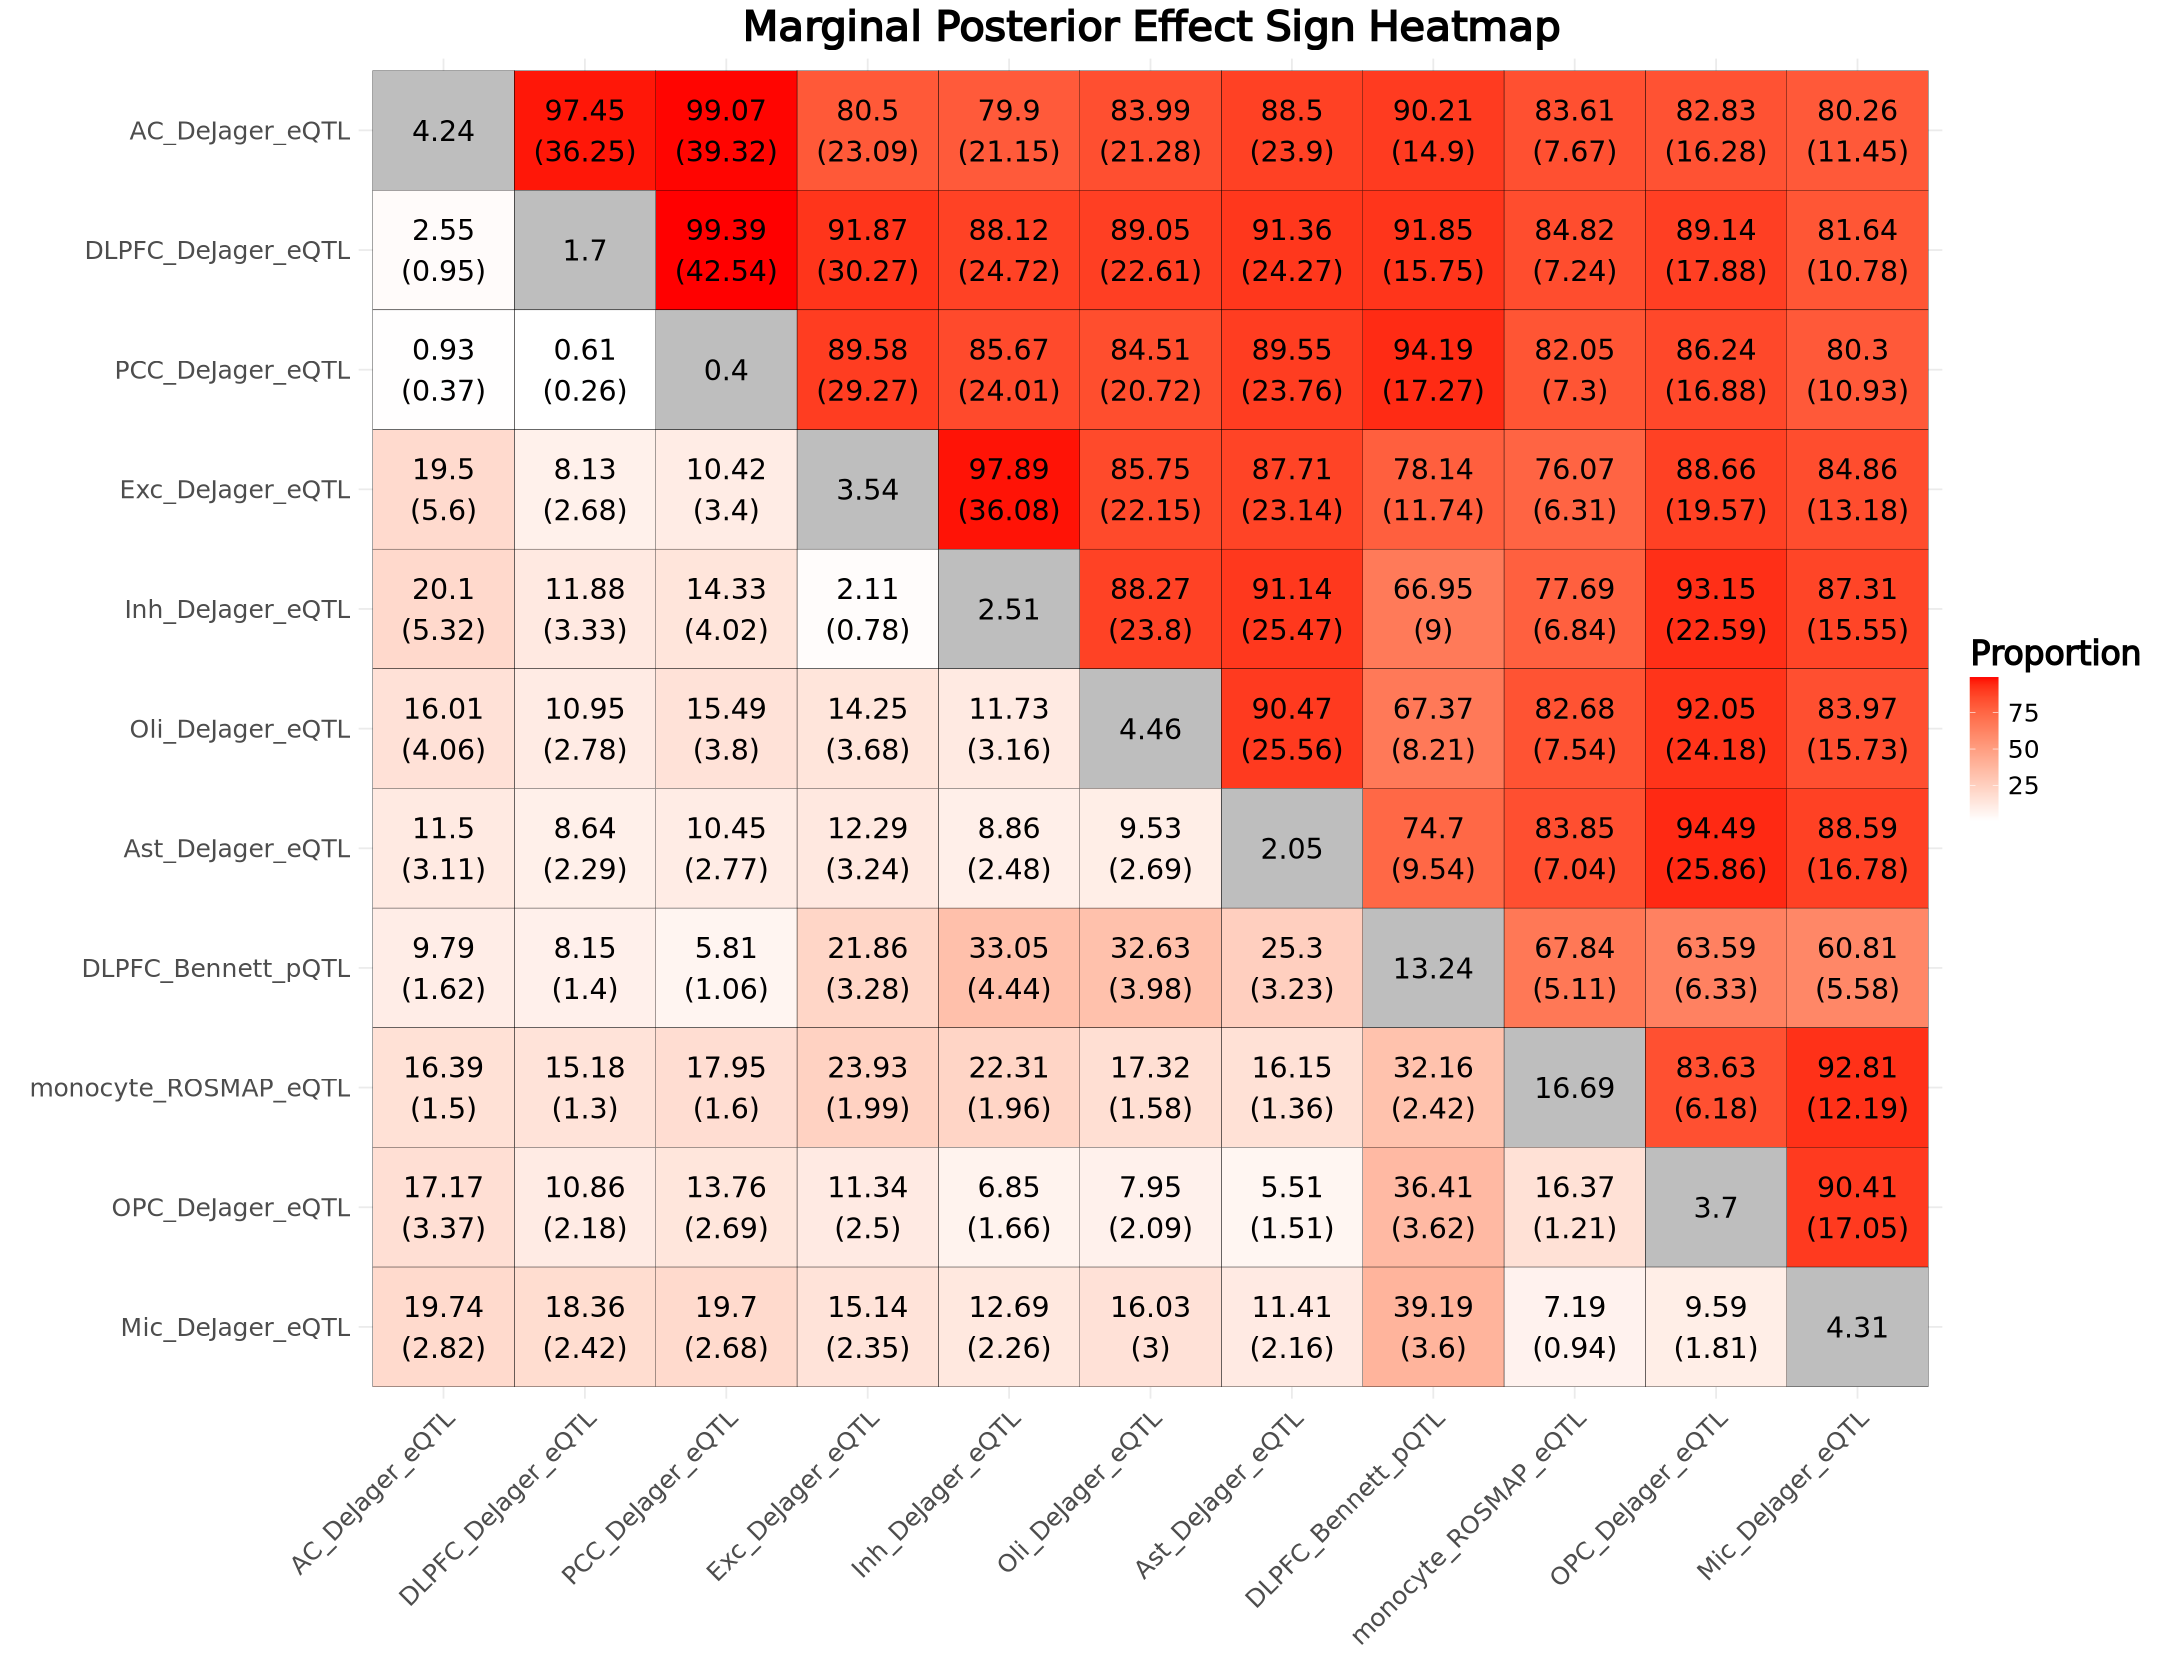

In [46]:
options(repr.plot.width = 18, repr.plot.height = 14)
p1

## multicontext effect sign heatmap

### trait_matrix

In [48]:
coverage <- "cs_coverage_0.95"
mvsusie_export_lfsr_integrated_df <- readRDS("~/project/Figure_2b/multicontext_top_loci_integrated.rds")
traits <- as.character(unique(mvsusie_export_lfsr_integrated_df%>%filter(event_ID!="")%>%pull(event_ID)))
intersected_gene_names <- posterior_dat_lfsr_effect_filtered_context_top_variants%>%
                                                        filter(context%in%traits)%>%
                                                        filter(gene%in%as.character(unique(mvsusie_export_lfsr_integrated_df%>%filter(event_ID!="")%>%
                                                                                           filter(.data[[coverage]]!=0)%>%pull(gene_ID)))) %>% pull(gene)%>%unique()
ROSMAP_multicontext_extracted <- ROSMAP_multicontext_res %>% filter(event_ID!="") %>% filter(gene_ID%in%intersected_gene_names)
num_traits <- length(traits)
trait_matrix <- matrix(0, nrow = num_traits, ncol = num_traits)  # Initialize matrix
rownames(trait_matrix) <- colnames(trait_matrix) <- traits   # Assign trait names
for (gene_name in intersected_gene_names){
#gene_name <- as.character(unique(mvsusie_export_lfsr_integrated_df$gene))[1]
#gene_name
# top_variants_lfsr_thres <-  mvsusie_export_lfsr_integrated_df%>%filter(gene_ID==gene_name)%>%
#                             filter(.data[[coverage]]!=0)%>%group_by(.data[[coverage]])%>% 
#                             filter(PIP == max(PIP, na.rm = TRUE)) %>%
#                             distinct(variant_ID, .keep_all = TRUE) %>%  # Ensure unique SNPs
#                             summarise(variant_ID = sample(variant_ID, 1), .groups = "drop")%>%
#                             pull(variant_ID) #top_variants_lfsr_thres
top_variants_lfsr_thres <- ROSMAP_multicontext_extracted%>%filter(gene_ID==gene_name)%>%
                            filter(.data[[coverage]]!=0)%>%group_by(.data[[coverage]],event_ID)%>% 
                            filter(PIP == max(PIP, na.rm = TRUE)) %>% slice_sample(n=1) %>% 
                            pull(variant_ID) %>% unique()
# Step 2: Iterate through variants in df2
for (variant in top_variants_lfsr_thres) {
  #variant <- 'chr20:50961558:T:C'
  # Extract rows from df1 where the marker matches the variant in df2
  variant_data <- mvsusie_export_lfsr_integrated_df %>% filter(gene_ID==gene_name)%>%filter(variant_ID == variant)
  #variant_data
  # If variant is found in multiple traits, compare effect signs
  if (nrow(variant_data) > 1) {
    
    # Get unique trait pairs
    for (i in 1:(nrow(variant_data) - 1)) {
      for (j in (i + 1):nrow(variant_data)) {
        
        trait_i <- variant_data$event_ID[i]
        trait_j <- variant_data$event_ID[j]
        
        effect_sign_i <- variant_data$effect_sign[i]
        effect_sign_j <- variant_data$effect_sign[j]

        # Find indices in the trait matrix
idx_i <- which(traits == trait_i)
idx_j <- which(traits == trait_j)
        
       # Ensure idx_i is always smaller than idx_j for upper triangle updates
if (idx_i > idx_j) {
  temp <- idx_i
  idx_i <- idx_j
  idx_j <- temp
}

# Update matrix correctly with only +1 increments
if (effect_sign_i == effect_sign_j) {
          trait_matrix[idx_i, idx_j] <- trait_matrix[idx_i, idx_j] + 1  # Always upper triangle
    } else {
          trait_matrix[idx_j, idx_i] <- trait_matrix[idx_j, idx_i] + 1  # Always lower triangle
}
      }
    }
  }
  
  # Step 3: Check if the variant is **context-specific**
  if (nrow(variant_data) == 1) {
    trait_idx <- which(traits == variant_data$event_ID)
    trait_matrix[trait_idx, trait_idx] <- trait_matrix[trait_idx, trait_idx] + 1  # Diagonal increment
  }
}
}


trait_matrix

,AC_DeJager_eQTL,DLPFC_DeJager_eQTL,PCC_DeJager_eQTL,Exc_DeJager_eQTL,Inh_DeJager_eQTL,Oli_DeJager_eQTL,Ast_DeJager_eQTL,DLPFC_Bennett_pQTL,monocyte_ROSMAP_eQTL,OPC_DeJager_eQTL,Mic_DeJager_eQTL
AC_DeJager_eQTL,245,4945,4955,2877,2064,1833,2197,1276,527,1062,558
DLPFC_DeJager_eQTL,217,106,5264,3629,2456,2026,2400,1326,511,1283,623
PCC_DeJager_eQTL,72,69,15,3374,2275,1747,2161,1321,483,1120,587
Exc_DeJager_eQTL,675,399,409,98,2992,1769,2026,882,413,1203,665
Inh_DeJager_eQTL,458,290,305,70,86,1644,1842,462,337,1150,636
Oli_DeJager_eQTL,304,206,230,231,128,172,1617,357,304,1076,536
Ast_DeJager_eQTL,297,205,226,194,111,97,58,430,290,1200,555
DLPFC_Bennett_pQTL,182,160,114,271,227,165,167,391,173,189,138
monocyte_ROSMAP_eQTL,146,139,137,159,105,76,81,78,42,174,272
OPC_DeJager_eQTL,215,135,152,112,59,43,43,107,47,77,393


### heatmap

In [51]:
trait_matrix <- trait_matrix[order(factor(rownames(trait_matrix), levels = rownames(trait_matrix))), 
                           order(factor(colnames(trait_matrix), levels = rownames(trait_matrix)))]
rev_trait_matrix <- trait_matrix[,ncol(trait_matrix):1]
#rev_trait_matrix <- t(trait_matrix)
rev_trait_matrix <- t(rev_trait_matrix)

# Calculate the fraction matrix
# Assuming rev_trait_matrix is your input square matrix
context_names <- colnames(rev_trait_matrix)
n <- length(context_names)

# Initialize output matrix
proportion_matrix <- matrix(NA, nrow = n, ncol = n)
colnames(proportion_matrix) <- rownames(proportion_matrix) <- context_names 

pairwise_proportion_matrix <- matrix(NA, nrow = n, ncol = n)
colnames(pairwise_proportion_matrix) <- rownames(pairwise_proportion_matrix) <- context_names 

for (i in seq_len(n)) {
  for (j in seq_len(n)) {
    if (i != j) {
      # Extract 2x2 submatrix
      trait_i <- colnames(trait_matrix)[i]
      trait_j <- colnames(trait_matrix)[j]
      pattern <- pattern <- str_c(trait_i, trait_j, sep = "|")
      submat <- trait_matrix[c(i, j), c(i, j)]
      ROSMAP_multicontext_res_filtered <- ROSMAP_multicontext_extracted %>% filter(event_ID!="")%>%
                                        filter(str_detect(event_ID,pattern)) %>% 
                                        select(gene_ID, event_ID,.data[[coverage]]) %>% unique() %>%
                                        filter(.data[[coverage]]!=0)
      pairwise_total_sum <- sum(submat) - sum(diag(submat))
      total_sum <- pairwise_total_sum +  dim(ROSMAP_multicontext_res_filtered)[1]
      value <- trait_matrix[i, j]

      # Compute and assign proportion
      proportion_matrix[i, j] <- round((value / total_sum)*100, 2)
      pairwise_proportion_matrix[i, j] <- round((value / pairwise_total_sum)*100, 2)
    }
  }
}

#proportion_matrix
rev_proportion_matrix <- proportion_matrix[, ncol(proportion_matrix):1]
rev_proportion_matrix <- t(rev_proportion_matrix)

# Convert matrix into long format for ggplot
df <- reshape2::melt(rev_proportion_matrix)
colnames(df) <- c("Trait1", "Trait2", "Count")

# 1. Identify which rows need filling
na_idx <- is.na(df$Count)

# 2. Pull from the matrix by name for those rows
# Find numeric row/col indices
r <- match(df$Trait1[na_idx], rownames(trait_matrix))
c <- match(df$Trait2[na_idx], colnames(trait_matrix))

# Do element-wise lookup
df$Count[na_idx] <- trait_matrix[cbind(r, c)]

#proportion_matrix

rev_pairwise_proportion_matrix <- pairwise_proportion_matrix[, ncol(pairwise_proportion_matrix):1]
rev_pairwise_proportion_matrix <- t(rev_pairwise_proportion_matrix)
 
df$Fraction <- as.vector(reshape2::melt(rev_pairwise_proportion_matrix)$value)

credible_sum <- ROSMAP_multicontext_extracted %>% filter(event_ID!="")%>%
                                        select(gene_ID, event_ID,.data[[coverage]]) %>% unique() %>%
                                        filter(.data[[coverage]]!=0)%>%nrow()

df <- df %>%
  rowwise() %>%
  mutate(
    Label = if (!is.na(Fraction)) {
      paste0(Fraction, "\n(", Count, ")")
    } else {
      total_genes <- ROSMAP_multicontext_extracted %>%
        filter(event_ID != "") %>%
        filter(str_detect(event_ID,as.character(Trait1))) %>%
        select(gene_ID, event_ID, .data[[coverage]]) %>%
        unique() %>%
        filter(.data[[coverage]] != 0) %>%
        nrow()
      
      round((Count / total_genes) * 100, 2) %>% as.character()
    }
  ) %>%
  ungroup()

df$Trait1 <- factor(df$Trait1, levels = rev(rownames(rev_proportion_matrix)))
df$Trait2 <- factor(df$Trait2, levels = rownames(rev_proportion_matrix))

#pdf("ROSMAP_multicontext_effect_sign_heatmap_4063_genes.pdf", width =10, height = 8)
# Plot heatmap using ggplot2
p2 <- ggplot(df, aes(x = Trait1, y = Trait2, fill = Fraction)) +
  geom_tile(color = "black") +
  scale_fill_gradient(low = "white", high = "red", na.value = "grey") +
  geom_text(aes(label = Label), size = 6) +  # Add text with count and fraction
  labs(x = "", y = "", fill = "Proportion", title = "Multicontext Posterior Effect Sign Heatmap") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 15),
        axis.text.y = element_text(size = 15),
        plot.title = element_text(hjust = 0.5, size = 25,face = "bold"),
        legend.title = element_text(size = 20,face = "bold"),
       legend.text = element_text(size = 15))
#dev.off()

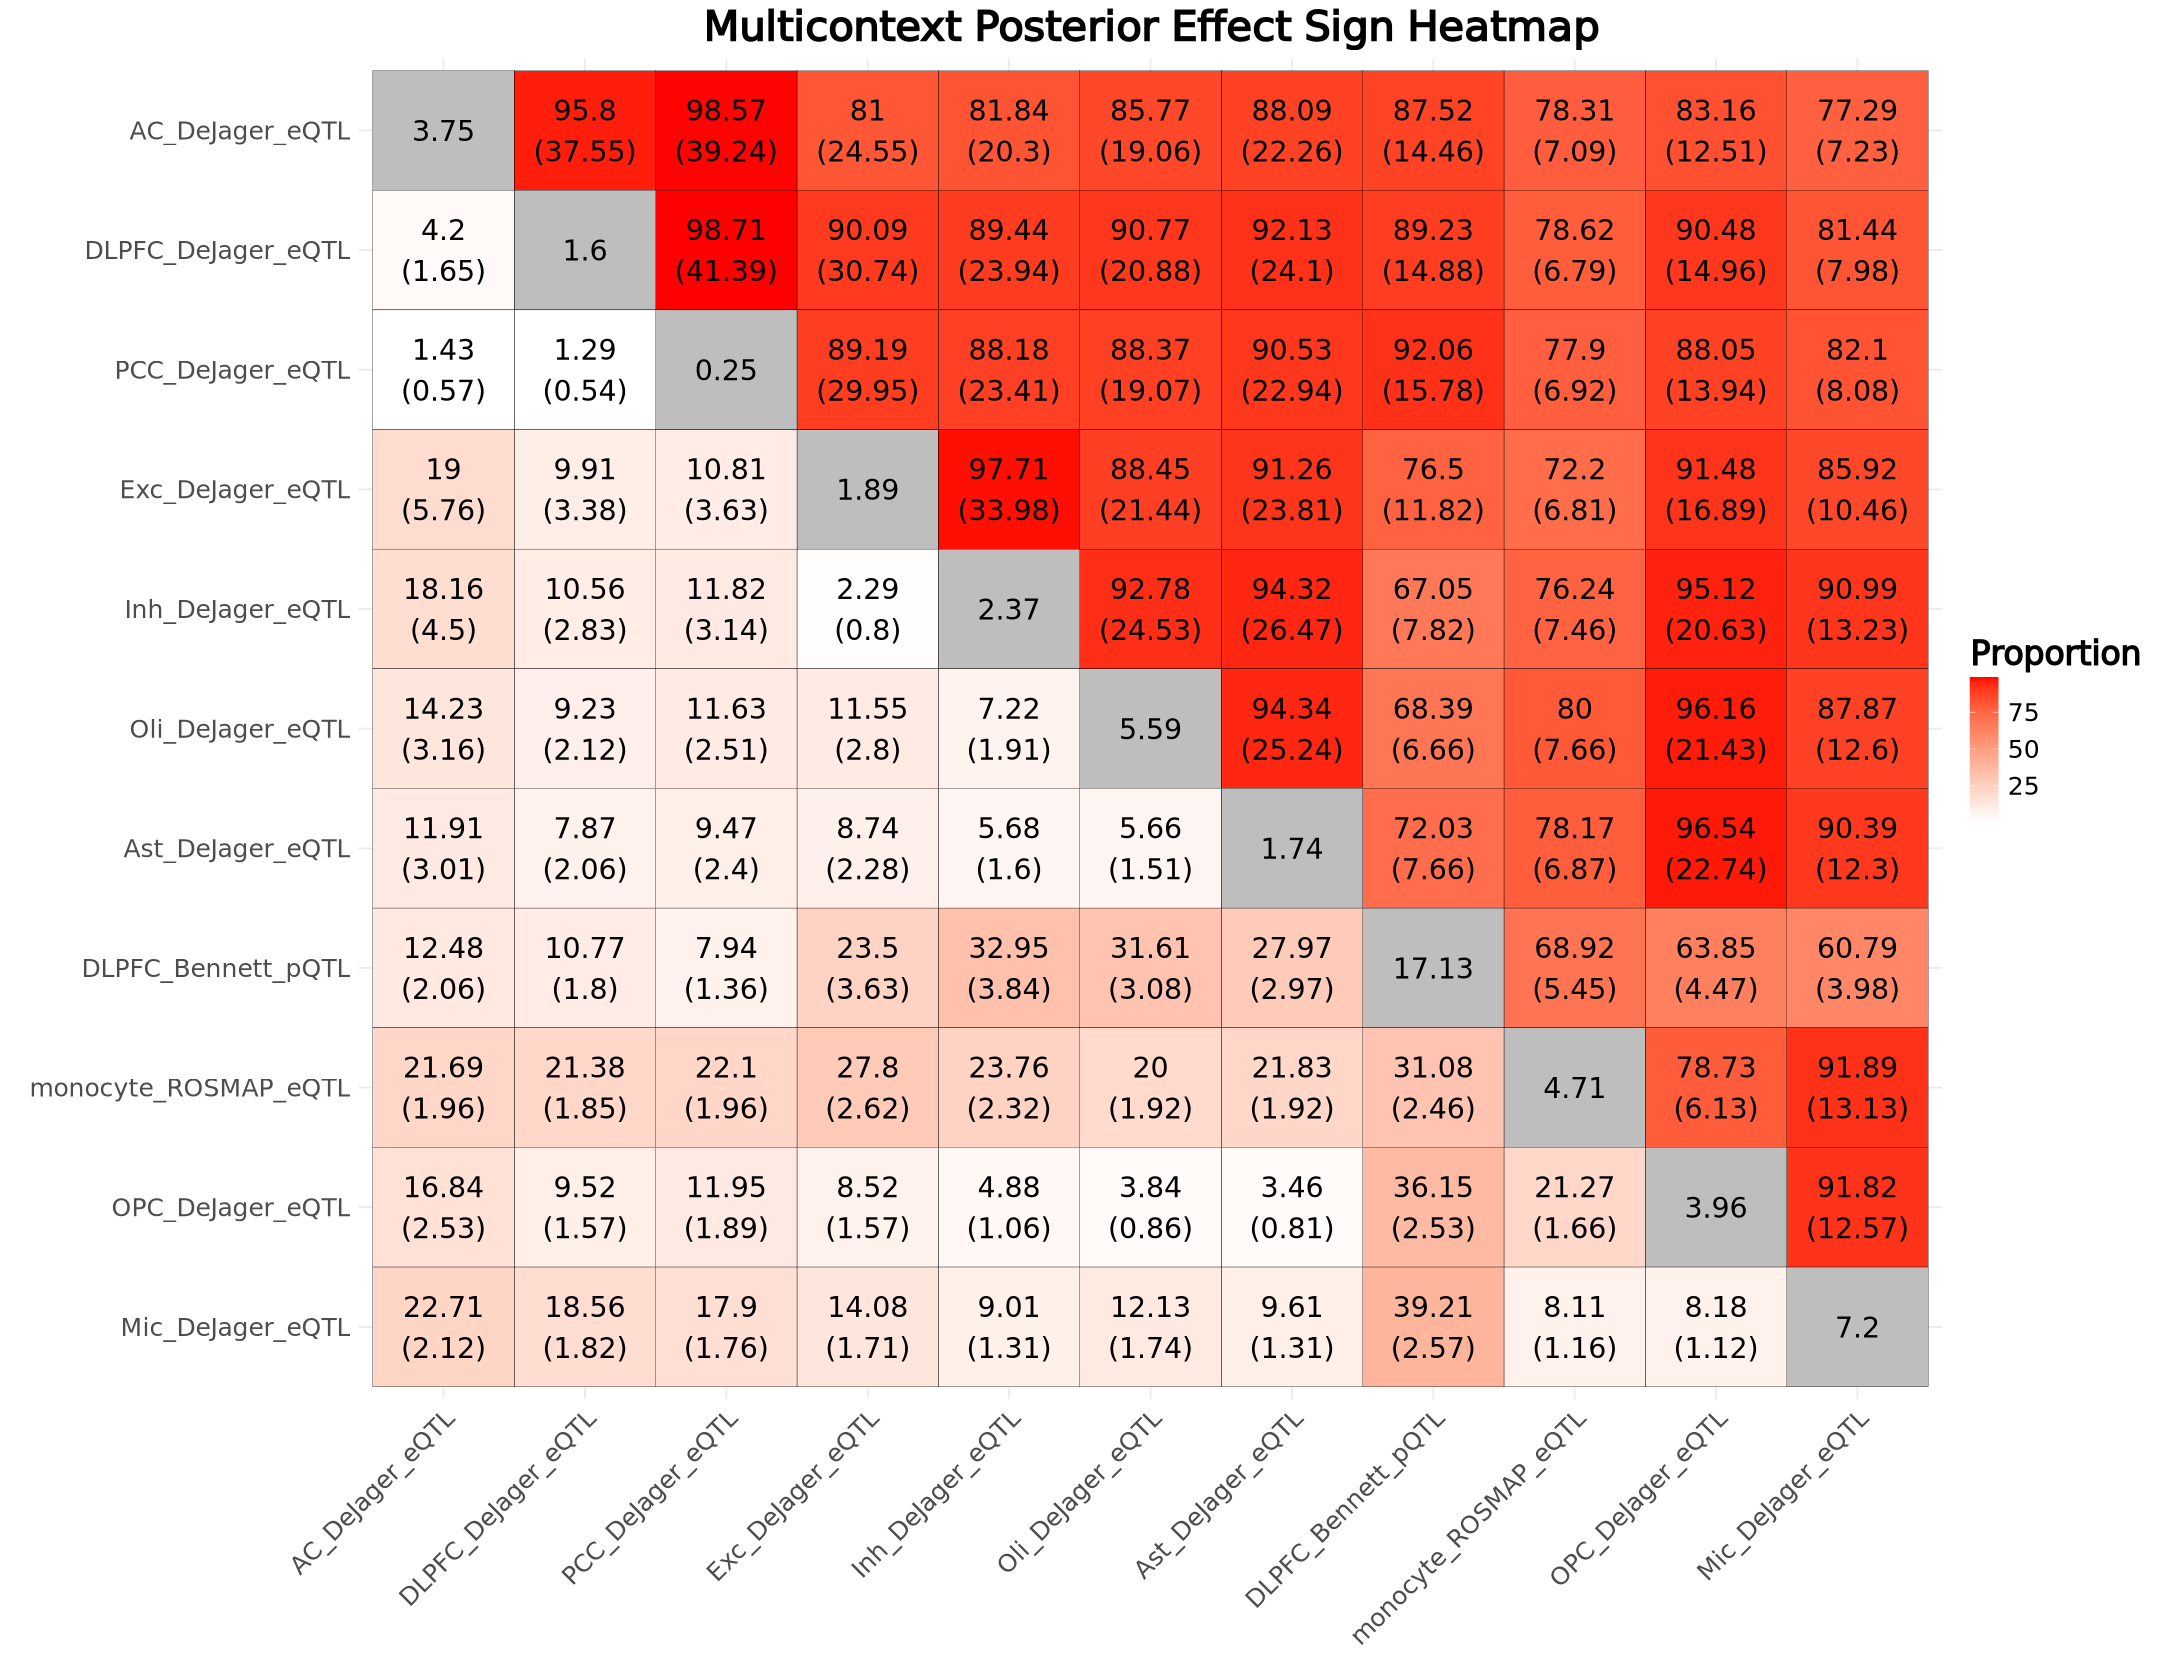

In [52]:
options(repr.plot.width = 18, repr.plot.height = 14)
p2